In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sqlalchemy import create_engine, text
from config.settings import Settings
import os

settings = Settings()

# ===== 1) MariaDB 접속 정보 설정 =====
DB_USER = settings.DB_USER
DB_PASSWORD = settings.DB_PASSWORD
DB_NAME = settings.DB_NAME

DB_HOST = "localhost" 
engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3307/{DB_NAME}?charset=utf8mb4"
)


In [89]:
with engine.connect() as conn:
    # 가장 최근 저장 시각 (created_at) 1개 가져오기
    latest_ts = pd.read_sql(
        "SELECT MAX(created_at) AS ts FROM holdings", conn
    )["ts"][0]

    print("가장 최근 스냅샷 시각:", latest_ts)

    # 그 시각에 해당하는 보유 종목들만 가져오기
    df = pd.read_sql(
        """
        SELECT stk_nm, evlt_amt, pl_rt
        FROM holdings
        WHERE created_at = %(ts)s
        ORDER BY evlt_amt DESC
        """,
        conn,
        params={"ts": latest_ts},
    )

# 숫자형으로 변환 (혹시 문자열이면)
df["pl_rt"] = pd.to_numeric(df["pl_rt"], errors="coerce")
df["evlt_amt"] = pd.to_numeric(df["evlt_amt"], errors="coerce")

# NaN(변환 실패) 제거
df = df.dropna(subset=["pl_rt", "evlt_amt"])

# ===== 3) 전체 포트 비중 계산 =====
total_value = df["evlt_amt"].sum()
df["weight"] = df["evlt_amt"] / total_value * 100  # %

가장 최근 스냅샷 시각: 2025-12-12 17:38:21


In [94]:
sql = r"""
WITH
latest_sd AS (
  SELECT MAX(snapshot_date) AS sd FROM holdings
),
latest_holdings AS (
  SELECT
    h.*,
    CASE
      WHEN LEFT(TRIM(h.stk_cd), 1) = 'A' THEN SUBSTRING(TRIM(h.stk_cd), 2)
      ELSE TRIM(h.stk_cd)
    END AS stk_cd_norm,
    CASE
      WHEN (h.loan_dt IS NOT NULL AND TRIM(h.loan_dt) <> '')
           OR (h.stk_nm LIKE '*%')
        THEN 'CREDIT'
      ELSE 'CASH'
    END AS crd_class_norm,
    TRIM(LEADING '*' FROM h.stk_nm) AS stk_nm_norm
  FROM holdings h
  JOIN latest_sd t ON t.sd = h.snapshot_date
  WHERE h.rmnd_qty > 0
),
open_pos AS (
  SELECT
    CASE
      WHEN LEFT(TRIM(pe.stk_cd), 1) = 'A' THEN SUBSTRING(TRIM(pe.stk_cd), 2)
      ELSE TRIM(pe.stk_cd)
    END AS stk_cd_norm,
    COALESCE(NULLIF(TRIM(pe.crd_class), ''), 'CASH') AS crd_class_norm,
    MIN(pe.start_dt) AS first_buy_dt
  FROM position_episodes pe
  WHERE pe.end_dt IS NULL
  GROUP BY
    CASE
      WHEN LEFT(TRIM(pe.stk_cd), 1) = 'A' THEN SUBSTRING(TRIM(pe.stk_cd), 2)
      ELSE TRIM(pe.stk_cd)
    END,
    COALESCE(NULLIF(TRIM(pe.crd_class), ''), 'CASH')
)
SELECT
  DATE(o.first_buy_dt) AS 첫_매수일,
  lh.stk_nm_norm       AS 종목명,
  lh.avg_prc           AS 매수평균가,
  ROUND(lh.pl_rt, 2)   AS 수익률_pct,
  DATEDIFF(CURDATE(), DATE(o.first_buy_dt)) AS 홀딩기간_일
FROM latest_holdings lh
JOIN open_pos o
  ON o.stk_cd_norm = lh.stk_cd_norm
 AND o.crd_class_norm = lh.crd_class_norm
ORDER BY o.first_buy_dt ASC, 종목명 ASC;
"""

df = pd.read_sql(text(sql), engine)

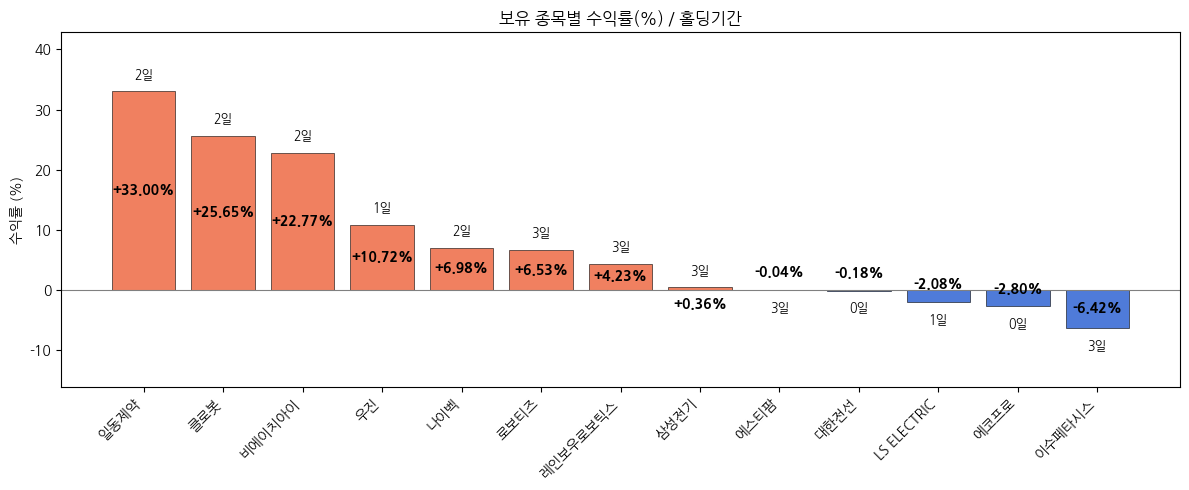

In [110]:
df2 = df.copy()

# 숫자 서식
df2["수익률(%)"] = df2["수익률_pct"].astype(float)
df2["홀딩기간(일)"] = df2["홀딩기간_일"].astype(int)

# 홀딩기간 긴 순으로 보고 싶으면
df3 = df2.sort_values(["수익률_pct"], ascending=[False]).head(30).reset_index(drop=True).drop(columns=["수익률_pct", "홀딩기간_일"])
plot_df = df3.copy()

x = np.arange(len(plot_df))
y = plot_df["수익률(%)"].astype(float).values
holding = plot_df["홀딩기간(일)"].astype(int).values
names = plot_df["종목명"].astype(str).values

plt.figure(figsize=(12, 5))

colors = ["#f08060" if v >= 0 else "#4f7bd9" for v in y]
bars = plt.bar(x, y, color=colors, edgecolor="black", linewidth=0.4)

plt.axhline(0, color="gray", linewidth=0.8)

plt.xticks(x, names, rotation=45, ha="right")
plt.ylabel("수익률 (%)")
plt.title("보유 종목별 수익률(%) / 홀딩기간")

# y축 여백
ymax = max(y.max(), 0)
ymin = min(y.min(), 0)
pad = max((ymax - ymin) * 0.25, 4)
plt.ylim(ymin - pad, ymax + pad)

# ─────────────────────────────
# 표시 로직
# ─────────────────────────────
INSIDE_THRESHOLD = 4.0   # 이 % 미만이면 막대 안에 글씨 못 넣는다고 판단
OFFSET = 1.8

for bar, ret, days in zip(bars, y, holding):
    cx = bar.get_x() + bar.get_width() / 2

    # ── 홀딩기간 (항상 바깥, 보통 크기, 검정) ──
    holding_y = ret + (OFFSET if ret >= 0 else -OFFSET)
    plt.text(
        cx,
        holding_y,
        f"{days}일",
        ha="center",
        va="bottom" if ret >= 0 else "top",
        fontsize=9,
        color="black"
    )

    # ── 수익률 위치 결정 ──
    if abs(ret) >= INSIDE_THRESHOLD:
        # 막대 안쪽
        ret_y = ret * 0.5
        va = "center"
    else:
        # 막대가 작으면 → 홀딩기간 반대편
        ret_y = ret - OFFSET if ret >= 0 else ret + OFFSET
        va = "top" if ret >= 0 else "bottom"

    plt.text(
        cx,
        ret_y,
        f"{ret:+.2f}%",
        ha="center",
        va=va,
        fontsize=10,
        color="black",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

In [99]:
x = np.arange(len(df_show))
y = df_show["수익률(%)"]
holding = df_show["홀딩기간(일)"]

plt.figure(figsize=(12, 5))

colors = ["#f08060" if v >= 0 else "#4f7bd9" for v in y]
bars = plt.bar(x, y, color=colors)

plt.axhline(0, color="gray", linewidth=0.8)

plt.xticks(x, df_plot["종목명"], rotation=45, ha="right")
plt.ylabel("수익률 (%)")
plt.title("보유 종목별 수익률(%)")

# 🔹 수익률 값 표시 + 홀딩기간 표시
for i, (bar, ret, days) in enumerate(zip(bars, y, holding)):
    height = bar.get_height()

    # 수익률 텍스트
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (0.6 if ret >= 0 else -0.6),
        f"{ret:.2f}%",
        ha="center",
        va="bottom" if ret >= 0 else "top",
        fontsize=9,
        fontweight="bold"
    )

    # 👉 홀딩기간 (작은 글씨)
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (2.0 if ret >= 0 else -2.0),
        f"{days}일",
        ha="center",
        va="bottom" if ret >= 0 else "top",
        fontsize=8,
        color="dimgray"
    )

plt.tight_layout()
plt.show()

TypeError: object of type 'Styler' has no len()

In [71]:
import dataframe_image as dfi

dfi.export(df_show, "holding_positions.png", table_conversion="chrome", dpi=200)

In [9]:
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

if not os.path.exists(font_path):
    raise FileNotFoundError("NanumGothic.ttf not found")

font_prop = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False

In [73]:
sql = r"""
WITH latest_sd AS (
  SELECT MAX(snapshot_date) AS sd FROM holdings
)
SELECT
  TRIM(LEADING '*' FROM stk_nm) AS stk_nm,
  SUM(evlt_amt) AS evlt_amt
FROM holdings h
JOIN latest_sd t ON t.sd = h.snapshot_date
WHERE h.rmnd_qty > 0
GROUP BY TRIM(LEADING '*' FROM stk_nm)
ORDER BY evlt_amt DESC;
"""

assets_df = pd.read_sql(text(sql), engine)

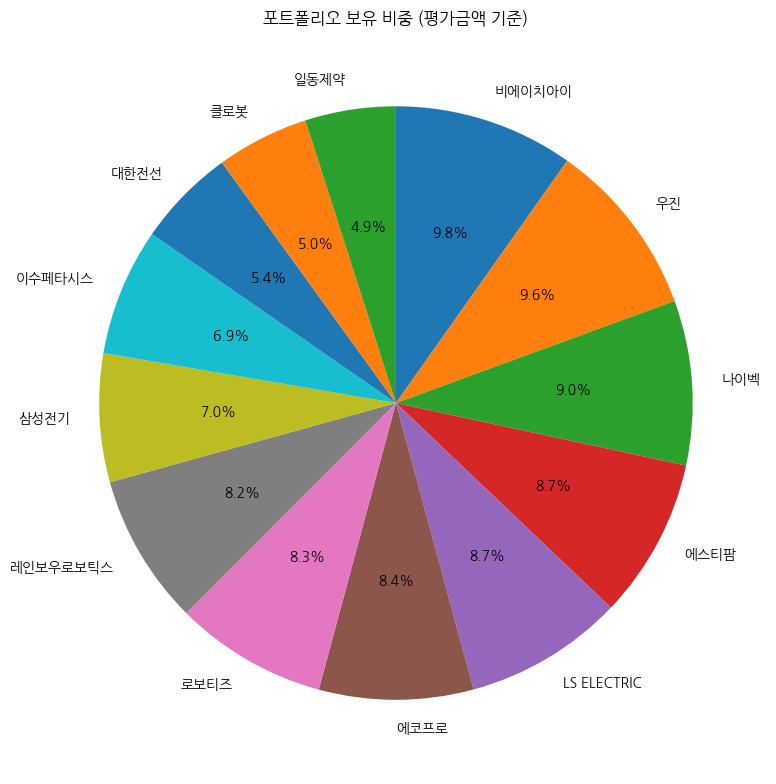

In [77]:
df_plot = assets_df.copy()
df_plot["evlt_amt"] = pd.to_numeric(df_plot["evlt_amt"], errors="coerce").fillna(0)
df_plot = df_plot[df_plot["evlt_amt"] > 0].sort_values("evlt_amt", ascending=False)

# 너무 많은 종목이면 상위 N개 + 기타로 묶기
TOP_N = 20
if len(df_plot) > TOP_N:
    top = df_plot.head(TOP_N).copy()
    other_sum = df_plot.iloc[TOP_N:]["evlt_amt"].sum()
    if other_sum > 0:
        top = pd.concat([top, pd.DataFrame([{"stk_nm":"기타", "evlt_amt":other_sum}])], ignore_index=True)
    df_plot = top

total = df_plot["evlt_amt"].sum()
df_plot["pct"] = df_plot["evlt_amt"] / total * 100

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    df_plot["evlt_amt"],
    labels=df_plot["stk_nm"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False
)
plt.title("포트폴리오 보유 비중 (평가금액 기준)")
plt.tight_layout()
plt.show()

In [86]:
sql = r"""
WITH
latest_sd AS (
  SELECT MAX(snapshot_date) AS sd FROM holdings
),
latest_holdings AS (
  SELECT
    h.*,
    CASE
      WHEN (h.loan_dt IS NOT NULL AND TRIM(h.loan_dt) <> '')
           OR (h.stk_nm LIKE '*%%')
        THEN 'CREDIT'
      ELSE 'CASH'
    END AS crd_class_norm
  FROM holdings h
  JOIN latest_sd t ON t.sd = h.snapshot_date
),
today_sells AS (
  SELECT
    ath.id AS sell_id,
    ath.trade_date,
    ath.ord_tm,
    ath.stk_cd,
    TRIM(LEADING '*' FROM ath.stk_nm) AS stk_nm,
    CASE
      WHEN (ath.loan_dt IS NOT NULL AND TRIM(ath.loan_dt) <> '')
           OR (ath.stk_nm LIKE '*%%')
        THEN 'CREDIT'
      ELSE 'CASH'
    END AS crd_class_norm,
    ath.cntr_uv AS sell_px
  FROM account_trade_history ath
  WHERE ath.trade_date = CURDATE()
    AND ath.io_tp_nm LIKE '%%매도%%'
)
SELECT
  s.trade_date                           AS 매도일,
  s.stk_nm                               AS 종목명,
  s.sell_px                              AS 매도가격,

  ROUND(
    SUM((lm.sell_px - lm.buy_px) * lm.match_qty)
    / NULLIF(SUM(lm.buy_px * lm.match_qty), 0) * 100
  , 2) AS 실현수익률_pct,

  CASE
    WHEN DATEDIFF(DATE(s.trade_date), DATE(MIN(lm.buy_dt))) = 0
      THEN 0
    ELSE DATEDIFF(DATE(s.trade_date), DATE(MIN(lm.buy_dt)))
  END AS 홀딩기간_일,

  CASE
    WHEN EXISTS (
      SELECT 1
      FROM latest_holdings h
      WHERE h.stk_cd = s.stk_cd
        AND h.crd_class_norm = s.crd_class_norm
        AND h.rmnd_qty > 0
    ) THEN 'Y'
    ELSE 'N'
  END AS 현재보유여부

FROM today_sells s
LEFT JOIN lot_matches lm
  ON lm.sell_source_id = s.sell_id
GROUP BY
  s.sell_id, s.trade_date, s.stk_nm, s.sell_px
ORDER BY
  실현수익률_pct DESC, 홀딩기간_일 DESC;
"""

df = pd.read_sql(sql, engine)

df2 = df.copy()

df2["실현수익률(%)"] = df2["실현수익률_pct"].astype(float)
df2["홀딩기간(일)"] = df2["홀딩기간_일"].astype(int)

df_show = (
    df2
    .drop(columns=["실현수익률_pct", "홀딩기간_일"])
    .sort_values(["실현수익률(%)", "홀딩기간(일)"], ascending=[False, False])
    .reset_index(drop=True)
    .style
    .hide(axis="index")
    .format({
        "매도가격": "{:,.0f}",
        "실현수익률(%)": "{:+.2f}%",
        "홀딩기간(일)": "{:d}"
    })
    .set_properties(subset=["홀딩기간(일)"], **{"text-align": "center"})
    .background_gradient(subset=["실현수익률(%)"], cmap="RdYlGn")
)

df_show

매도일,종목명,매도가격,현재보유여부,실현수익률(%),홀딩기간(일)
2025-12-12,클로봇,"59,900",Y,+15.64%,2
2025-12-12,서부T&D,"14,160",N,+0.64%,1


In [87]:
import dataframe_image as dfi

dfi.export(
    df_show,
    "today_trades_with_holding.png",
    table_conversion="matplotlib",
    dpi=200
)

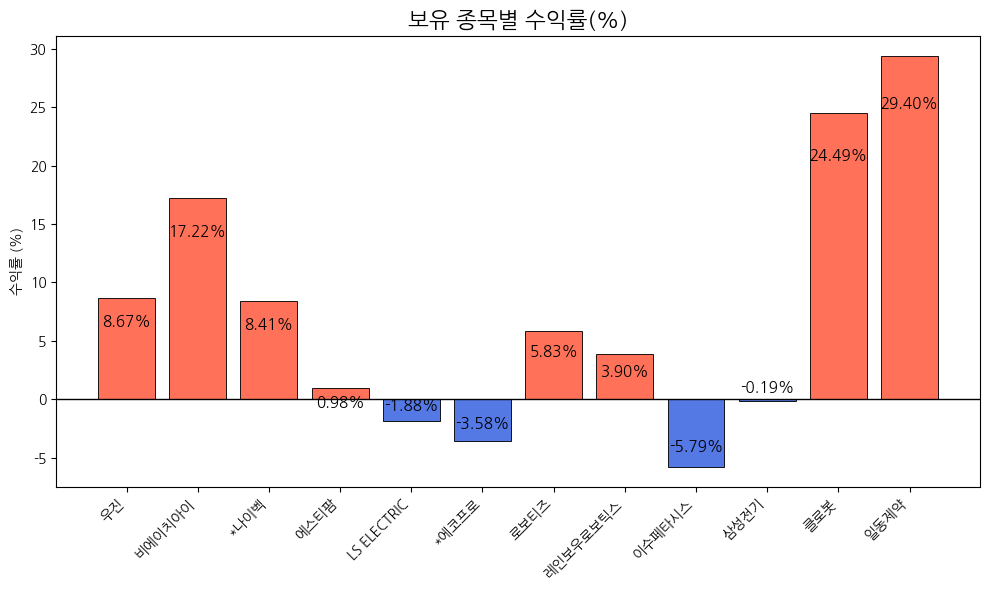

In [10]:
plt.figure(figsize=(10, 6))

# 색상 변경: 수익(+) = 빨간색 / 손실(-) = 파란색
colors = df["pl_rt"].apply(lambda x: "tomato" if x > 0 else "royalblue")

bars = plt.bar(
    df["stk_nm"],
    df["pl_rt"],
    color=colors,
    edgecolor="black",
    linewidth=0.7,
    alpha=0.9  # 살짝 입체감
)

plt.axhline(0, color="black", linewidth=1)
plt.title("보유 종목별 수익률(%)", fontsize=16)
plt.ylabel("수익률 (%)")
plt.xticks(rotation=45, ha="right")

# ----- 퍼센티지를 '막대 내부'에 표시 -----
for i, v in enumerate(df["pl_rt"]):
    if v >= 0:
        y = v - (abs(v) * 0.1 + 0.5)  # 막대 위쪽 내부
        va = "top"
    else:
        y = v + (abs(v) * 0.1 + 0.5)  # 막대 아래쪽 내부
        va = "bottom"

    plt.text(
        i,
        y,
        f"{v:.2f}%",
        ha="center",
        va=va,
        fontsize=11,
        color="black"          # 글씨색 모두 검정
    )

plt.tight_layout()
plt.show()


In [5]:
# today = datetime.now(kst).date()
target_date = "2025-12-11"

with engine.connect() as conn:
    df_trades = pd.read_sql(
        """
        SELECT
            query_date,
            stk_cd,
            stk_nm,
            cntr_qty,
            buy_uv,
            cntr_pric,
            tdy_sel_pl,
            pl_rt
        FROM realized_pnl_daily
        WHERE query_date = %(d)s
        ORDER BY stk_nm
        """,
        conn,
        params={"d": target_date},
    )

df_today = df_trades.copy()

df_today = df_today[[
    "query_date",
    "stk_nm",
    "buy_uv",
    "cntr_pric",
    "pl_rt",
]]

df_today.rename(columns={
    "query_date": "매도일",
    "stk_nm": "종목명",
    "buy_uv": "매수평균가",
    "cntr_pric": "매도가격",
    "pl_rt": "수익률(%)",
}, inplace=True)

In [6]:
def color_pnl(val):
    """수익률 색상: 플러스 빨강, 마이너스 파랑, 0은 회색"""
    try:
        v = float(val)
    except (TypeError, ValueError):
        return ""
    if v > 0:
        return "color: red; font-weight: bold;"
    elif v < 0:
        return "color: blue; font-weight: bold;"
    else:
        return "color: gray; font-weight: bold;"


styled = (
    df_today.style
        .format({
            "매수평균가": "{:,.0f}",
            "매도가격": "{:,.0f}",
            "수익률(%)": "{:.2f}",
        })
        .map(color_pnl, subset=["수익률(%)"])
        .hide(axis="index")  # 인덱스 제거
        .set_table_styles(
            [
                {"selector": "th", 
                 "props": [("font-weight", "bold"), ("background-color", "#f5f5f5")]},
                {"selector": "table",
                 "props": [("border-collapse", "collapse"), 
                           ("margin", "10px 0")]},
                {"selector": "td, th",
                 "props": [("border", "1px solid #ddd"), 
                           ("padding", "8px 12px"),
                           ("text-align", "center")]},
                {"selector": "tr:hover",
                 "props": [("background-color", "#fafafa")]}
            ]
        )
        .set_properties(**{
            "font-family": "NanumGothic",
            "font-size": "12pt"
        })
)

styled


매도일,종목명,매수평균가,매도가격,수익률(%)
2025-12-11,*에코프로비엠,"181,920","178,300",-2.20
2025-12-11,*에코프로비엠,"181,920","176,500",-3.19
2025-12-11,에코프로,"117,700","116,100",-1.54
2025-12-11,에코프로,"117,700","114,400",-2.98
2025-12-11,일동제약,"33,250","41,400",24.29
2025-12-11,코오롱인더,"46,850","46,050",-1.88
